In [25]:
import os, math, json, time, h5py, numpy as np, torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import roc_auc_score
from collections import deque
import pandas as pd
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def set_seed(seed=42):
    torch.manual_seed(seed); np.random.seed(seed)
set_seed(42)


## Model definition

In [2]:
def robust_stats_mad(arr):
    """Return (median, sigma) using MAD (robust to outliers)."""
    med = np.median(arr)
    mad = np.median(np.abs(arr - med))
    sigma = 1.4826 * (mad + 1e-12)  # 1.4826*MAD ~ std for normal
    return med, sigma

def robust_stats_iqr(arr):
    """Return (median, sigma) using IQR (P75-P25)."""
    med = np.median(arr)
    q25, q75 = np.percentile(arr, [25, 75])
    sigma = 0.741 * (q75 - q25 + 1e-12)  # 0.741*(IQR) ~ std for normal
    return med, sigma

class H5TiledDataset(Dataset):
    """
    Streams tiles from HDF5 and applies robust per-image or per-tile
    standardization + k-sigma clipping.

    clip_mode: 'robust_per_image' | 'robust_per_tile' | 'none'
    stat_fn  : robust function: robust_stats_mad (default) or robust_stats_iqr
    k_sigma  : clip to [-k_sigma, +k_sigma] after standardization
    image_crop_for_stats: (h, w) crop (contiguous) used to estimate per-image stats
                          None -> center square of size min(512, H, W)
    """
    def __init__(self, h5_path, tile=128,
                 clip_mode='robust_per_image',
                 stat_fn=robust_stats_mad,
                 k_sigma=5.0,
                 image_crop_for_stats=None):
        self.h5_path = h5_path
        self.tile    = tile
        self.clip_mode = clip_mode
        self.stat_fn = stat_fn
        self.k_sigma = float(k_sigma)
        self.image_crop_for_stats = image_crop_for_stats
        self._h5 = None
        self._stats_cache = {}  # image_id -> (med, sigma)

        with h5py.File(self.h5_path, "r") as f:
            self.N, self.H, self.W = f["images"].shape
            assert f["masks"].shape == (self.N, self.H, self.W)

        Hb = math.ceil(self.H / tile); Wb = math.ceil(self.W / tile)
        self.indices = [(i, r, c) for i in range(self.N) for r in range(Hb) for c in range(Wb)]

    def _ensure_open(self):
        if self._h5 is None:
            self._h5 = h5py.File(self.h5_path, "r")
            self.x = self._h5["images"]
            self.y = self._h5["masks"]

    def _get_image_stats(self, i):
        """Compute & cache robust (median, sigma) for image i using one contiguous crop."""
        if i in self._stats_cache:
            return self._stats_cache[i]

        H, W = self.H, self.W
        if self.image_crop_for_stats is None:
            s = min(512, H, W)
            h0 = (H - s) // 2
            w0 = (W - s) // 2
            h1, w1 = h0 + s, w0 + s
        else:
            sH, sW = self.image_crop_for_stats
            sH = min(sH, H); sW = min(sW, W)
            h0 = (H - sH) // 2
            w0 = (W - sW) // 2
            h1, w1 = h0 + sH, w0 + sW

        # single contiguous read → fast even on unchunked files
        crop = self.x[i, h0:h1, w0:w1].astype("float32")
        med, sigma = self.stat_fn(crop)
        if not np.isfinite(sigma) or sigma <= 0:
            sigma = np.float32(1.0)

        self._stats_cache[i] = (np.float32(med), np.float32(sigma))
        return self._stats_cache[i]

    def _normalize_and_clip(self, tile_arr, med, sigma):
        x = (tile_arr - med) / sigma
        if self.k_sigma > 0:
            x = np.clip(x, -self.k_sigma, +self.k_sigma)
        return x

    def __len__(self): return len(self.indices)

    def __getitem__(self, idx):
        self._ensure_open()
        i, r, c = self.indices[idx]
        t = self.tile
        r0, c0 = r*t, c*t
        r1, c1 = min(r0 + t, self.H), min(c0 + t, self.W)

        x = self.x[i, r0:r1, c0:c1].astype("float32")
        y = self.y[i, r0:r1, c0:c1].astype("float32")

        # pad edges to (t,t)
        if x.shape[0] != t or x.shape[1] != t:
            xp = np.zeros((t, t), np.float32)
            yp = np.zeros((t, t), np.float32)
            xp[:x.shape[0], :x.shape[1]] = x
            yp[:y.shape[0], :y.shape[1]] = y
            x, y = xp, yp

        # Robust clipping/standardization
        if self.clip_mode == 'robust_per_image':
            med, sigma = self._get_image_stats(i)
            x = self._normalize_and_clip(x, med, sigma)
        elif self.clip_mode == 'robust_per_tile':
            med, sigma = self.stat_fn(x)
            if not np.isfinite(sigma) or sigma <= 0: sigma = np.float32(1.0)
            x = self._normalize_and_clip(x, med, sigma)
        elif self.clip_mode == 'none':
            pass
        else:
            raise ValueError(f"Unknown clip_mode: {self.clip_mode}")

        return torch.from_numpy(x[None, ...]), torch.from_numpy(y[None, ...])

In [3]:
class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Sequential(nn.Conv2d(F_g, F_int, 1, bias=False), nn.BatchNorm2d(F_int))
        self.W_x = nn.Sequential(nn.Conv2d(F_l, F_int, 1, bias=False), nn.BatchNorm2d(F_int))
        self.psi = nn.Sequential(nn.Conv2d(F_int, F_l, 1, bias=False), nn.BatchNorm2d(F_l), nn.Sigmoid())
        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g); x1 = self.W_x(x)
        if g1.shape[-2:] != x1.shape[-2:]:
            g1 = F.interpolate(g1, size=x1.shape[-2:], mode='bilinear', align_corners=False)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi


def conv_bn_act(in_ch, out_ch, k=3, act='relu', name=''):
    layers = [nn.Conv2d(in_ch, out_ch, k, padding=k//2, bias=False),
              nn.BatchNorm2d(out_ch)]
    if act.lower() == 'relu': layers += [nn.ReLU(inplace=True)]
    elif act.lower() == 'selu': layers += [nn.SELU(inplace=True)]
    elif act.lower() == 'elu': layers += [nn.ELU(inplace=True)]
    else: layers += [nn.ReLU(inplace=True)]
    return nn.Sequential(*layers)

class EncoderBlock(nn.Module):
    def __init__(self, in_ch, out_ch, act='relu', dropout=0.0, max_pool=True):
        super().__init__()
        self.conv1 = conv_bn_act(in_ch, out_ch, 3, act)
        self.conv2 = conv_bn_act(out_ch, out_ch, 3, act)
        self.drop = nn.Dropout2d(dropout) if dropout>0 else nn.Identity()
        self.pool = nn.MaxPool2d(2) if max_pool else nn.Identity()
    def forward(self, x):
        x = self.conv1(x); x = self.conv2(x); x = self.drop(x)
        skip = x
        x = self.pool(x)
        return x, skip

class DecoderBlock(nn.Module):
    def __init__(self, in_ch, skip_ch, out_ch, act='relu', dropout=0.0, do_up=True, use_attn=True):
        super().__init__()
        self.skip_ch = skip_ch
        up_out_ch = in_ch if (skip_ch == 0) else skip_ch
        self.up = (nn.Sequential(
            nn.ConvTranspose2d(in_ch, up_out_ch, 3, stride=2, padding=1, output_padding=1, bias=False),
            nn.BatchNorm2d(up_out_ch),
            nn.ReLU(inplace=True) if act=='relu' else nn.SELU(inplace=True)
        ) if do_up else nn.Identity())

        self.attn = (AttentionGate(up_out_ch, skip_ch, max(1, skip_ch//2))
                     if (use_attn and skip_ch > 0) else nn.Identity())

        conv1_in = up_out_ch if skip_ch == 0 else (up_out_ch + skip_ch)
        self.conv1 = conv_bn_act(conv1_in, out_ch, 3, act)
        self.conv2 = conv_bn_act(out_ch, out_ch, 3, act)
        self.drop  = nn.Dropout2d(dropout) if dropout > 0 else nn.Identity()

    def forward(self, x, skip=None):
        x = self.up(x)
        if self.skip_ch > 0 and skip is not None:
            # (optional safety) align x to skip spatially
            if x.shape[-2:] != skip.shape[-2:]:
                x = F.interpolate(x, size=skip.shape[-2:], mode='bilinear', align_corners=False)
            skip = self.attn(x, skip)
            x = torch.cat([x, skip], dim=1)
        x = self.conv1(x); x = self.conv2(x); x = self.drop(x)
        return x


class UNetTFParity(nn.Module):
    """
    Parity with your TF unet_model:
      - BN on input
      - encoder/decoder stacks per JSON architecture
      - attention gates on decoder merges
      - final 1-ch sigmoid
    """
    def __init__(self, in_ch=1, arch=None, kernel_size=3):
        super().__init__()
        assert arch is not None, "Provide architecture dict with keys like TF: downFilters, downActivation, downDropout, downMaxPool, upFilters, upActivation, upDropout."
        self.input_bn = nn.BatchNorm2d(in_ch)

        # Build encoders
        self.enc = nn.ModuleList()
        prev = in_ch
        for nf, act, drop, mp in zip(arch["downFilters"], arch["downActivation"], arch["downDropout"], arch["downMaxPool"]):
            self.enc.append(EncoderBlock(prev, nf, act, drop, max_pool=mp))
            prev = nf

        # Build decoders (reverse skips)
        self.dec = nn.ModuleList()
        skip_chs = arch["downFilters"][:]   # channels of each encoder output
        for i, (nf, act, drop) in enumerate(zip(arch["upFilters"], arch["upActivation"], arch["upDropout"])):
            in_ch_dec = skip_chs[-1] if i == 0 else arch["upFilters"][i-1]
            skip_ch   = 0         if i == 0 else skip_chs[-1-i]   # no deepest skip
            self.dec.append(DecoderBlock(in_ch_dec, skip_ch, nf, act, drop, do_up=True, use_attn=True))


        self.out_conv = nn.Conv2d(arch["upFilters"][-1], 1, kernel_size, padding=kernel_size//2)
        self.out_act  = nn.Sigmoid()

    def forward(self, x):
        x = self.input_bn(x)
        skips = []
        for i, blk in enumerate(self.enc):
            x, skip = blk(x)
            # Keep last skip as None (parity with TF code that appends None for the deepest) :contentReference[oaicite:10]{index=10}
            skips.append(skip if i < len(self.enc)-1 else None)

        # forward stays the same:
        x = self.dec[0](x, skips[-1])       # skips[-1] is None; block was built with skip_ch=0
        for i in range(1, len(self.dec)):
            x = self.dec[i](x, skips[-1 - i])


        x = self.out_conv(x)
        return self.out_act(x)


In [4]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0): super().__init__(); self.smooth = smooth
    def forward(self, p, t):
        p = p.contiguous().view(-1); t = t.contiguous().view(-1)
        inter = (p*t).sum()
        return 1 - (2*inter + self.smooth) / (p.sum() + t.sum() + self.smooth)

class FocalTverskyLoss(nn.Module):
    def __init__(self, alpha=0.9, gamma=2.0, eps=1.0, beta=None):
        super().__init__()
        self.alpha, self.gamma, self.eps = alpha, gamma, eps
        self.beta = 1 - alpha if beta is None else beta  # parity with TF tversky() weighting

    def forward(self, p, t):
        p = p.contiguous().view(-1); t = t.contiguous().view(-1)
        TP = (p*t).sum(); FP = (p*(1-t)).sum(); FN = ((1-p)*t).sum()
        tversky = (TP + self.eps) / (TP + self.alpha*FN + self.beta*FP + self.eps)
        return torch.pow(1 - tversky, self.gamma)

@torch.no_grad()
def prf1_at_threshold(p, t, thresh=0.5):
    pb = (p >= thresh).float()
    tp = (pb*t).sum().item(); fp = (pb*(1-t)).sum().item(); fn = ((1-pb)*t).sum().item()
    prec = tp / (tp+fp+1e-8); rec = tp / (tp+fn+1e-8)
    f1 = 2*prec*rec/(prec+rec+1e-8)
    return prec, rec, f1


In [5]:
def resize_masks_to(pred, masks):
    """Resize masks to pred spatial size using bilinear, then ceil to {0,1}."""
    H, W = pred.shape[-2:]
    m = F.interpolate(masks.float(), size=(H, W), mode='bilinear', align_corners=False)
    return torch.ceil(m).clamp_(0, 1)


In [6]:
arch = {
    "downFilters":   [32, 32, 64, 128, 256, 512, 1024],
    "downActivation":["relu","selu","selu","selu","selu","selu","selu"],
    "downDropout":   [0.0, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
    "downMaxPool":   [True, True, True, True, True, True, False],  # 6 pools
    # upFilters must have length == number of True in downMaxPool == 6
    "upFilters":     [1024, 512, 256, 128, 64, 32],                # ← add the final 32
    "upActivation":  ["selu","selu","selu","selu","selu","relu"],  # ← add one act
    "upDropout":     [0.1, 0.1, 0.1, 0.1, 0.1, 0.0],               # ← add one drop
}


In [7]:
train_h5 = "/home/karlo/train_chunked.h5"   # change if needed
tile = 128

full_ds = H5TiledDataset(train_h5, tile=tile)
n = len(full_ds); n_tr = int(0.8*n); n_va = n - n_tr
train_ds, val_ds = random_split(full_ds, [n_tr, n_va], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True,  num_workers=32, pin_memory=False)
val_loader   = DataLoader(val_ds,   batch_size=64, shuffle=False, num_workers=32, pin_memory=False)

xb, yb = next(iter(train_loader))
print("Batch:", xb.shape, yb.shape)


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/home/karlo/train_chunked.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [8]:
model = UNetTFParity(in_ch=1, arch=arch, kernel_size=5).to(device)
criterion = FocalTverskyLoss(alpha=0.95, gamma=3.1)
optimizer = torch.optim.Adam(model.parameters(), lr=1.5e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.75, patience=4)

## Training

In [ ]:
def run_epoch(loader, train=True, tag="Train", print_every=10, compute_auc=False):
    """
    Live inline progress on one line. No AUC in-batch. If compute_auc=True,
    AUC is computed once at the end over the whole split.
    """
    model.train(train)
    start = time.time()
    total = len(loader.dataset)
    seen = 0
    running_loss = 0.0
    tp = fp = fn = 0.0

    # Only used if compute_auc=True (e.g., on validation)
    if compute_auc:
        preds_all = []
        targs_all = []

    for b, (xb, yb) in enumerate(loader, start=1):
        xb, yb = xb.to(device), yb.to(device)

        with torch.set_grad_enabled(train):
            out = model(xb)                     # sigmoid probs
            yb_r = resize_masks_to(out, yb)     # resize + ceil
            loss = criterion(out, yb_r)
            if train:
                optimizer.zero_grad(set_to_none=True)
                loss.backward()
                optimizer.step()

        bs = xb.size(0)
        seen += bs
        running_loss += float(loss.item()) * bs

        with torch.no_grad():
            p = out.detach().cpu().view(-1)     # 1D CPU tensors
            t = yb_r.detach().cpu().view(-1)

            # thresholded metrics (exact, O(1) memory)
            p_bin = (p >= 0.5).float()
            tp += float((p_bin * t).sum())
            fp += float((p_bin * (1 - t)).sum())
            fn += float(((1 - p_bin) * t).sum())

            # accumulate only for final AUC (validation)
            if compute_auc:
                preds_all.append(p.numpy())
                targs_all.append(t.numpy())

        if ((b % print_every == 0) or (seen == total)) and train:
            prec = tp / (tp + fp + 1e-8)
            rec  = tp / (tp + fn + 1e-8)
            f1   = 2 * prec * rec / (prec + rec + 1e-8)
            avg_loss = running_loss / seen
            elapsed = time.time() - start
            print(
                f"\r[{tag}] batch {b}/{len(loader)} | {seen}/{total} ex | "
                f"loss={avg_loss:.4f} | F1 {f1:.4f} | P {prec:.4f} | R {rec:.4f} | {elapsed:.1f}s",
                end='', flush=True
            )

    if train:
        print()  # newline after epoch

    # Final AUC only if requested (e.g., on validation)
    if compute_auc:
        try:
            P = np.concatenate(preds_all, 0)
            T = np.concatenate(targs_all, 0)
            auc = roc_auc_score(T, P)
        except Exception:
            auc = float('nan')
    else:
        auc = float('nan')

    prec = tp / (tp + fp + 1e-8)
    rec  = tp / (tp + fn + 1e-8)
    f1   = 2 * prec * rec / (prec + rec + 1e-8)
    epoch_loss = running_loss / total
    return epoch_loss, auc, prec, rec, f1



def fit(epochs=20, early_stop_patience=10):
    best_f1, epochs_no_improve = -1, 0
    for ep in range(1, epochs+1):
        t0 = time.time()
        # Train: no AUC, lightweight
        tr_loss, _, tr_p, tr_r, tr_f1 = run_epoch(train_loader, train=True,  tag="Train", print_every=10, compute_auc=False)
        # Val: compute AUC once at the end
        va_loss, va_auc, va_p, va_r, va_f1 = run_epoch(val_loader,   train=False, tag="Val",   print_every=10, compute_auc=True)

        scheduler.step(va_loss)

        print(f"Epoch {ep:03d} | "
              f"Train L {tr_loss:.4f} F1 {tr_f1:.4f} P {tr_p:.4f} R {tr_r:.4f} || "
              f"Val L {va_loss:.4f} AUC {va_auc:.4f} F1 {va_f1:.4f} P {va_p:.4f} R {va_r:.4f} | "
              f"{time.time()-t0:.1f}s")

        if va_f1 > best_f1 + 1e-4:
            best_f1, epochs_no_improve = va_f1, 0
            torch.save({"state_dict": model.state_dict(), "arch": arch}, "./best_unet_tf_parity.pt")
        else:
            epochs_no_improve += 1
        if epochs_no_improve >= early_stop_patience:
            print("Early stopping."); break


fit(epochs=20, early_stop_patience=10)


[Train] batch 10240/10240 | 655360/655360 ex | loss=0.5200 | F1 0.0757 | P 0.0411 | R 0.4811 | 566.3s
Epoch 001 | Train L 0.5200 AUC nan F1 0.0757 P 0.0411 R 0.4811 || Val L 0.4942 AUC nan F1 0.1033 P 0.0576 R 0.4978 | 616.9s
[Train] batch 2820/10240 | 180480/655360 ex | loss=0.5120 | F1 0.0775 | P 0.0421 | R 0.4865 | 158.0s

## Evaluate

In [11]:
model.load_state_dict(torch.load("./best_unet_tf_parity.pt", weights_only=True))

<All keys matched successfully>

In [12]:
test_h5 = "../DATA/test.h5"              # <-- change if needed
tile = 128
test_ds = H5TiledDataset(
    test_h5, tile=tile,
    clip_mode='robust_per_image',
    stat_fn=robust_stats_mad,
    k_sigma=5.0,
    image_crop_for_stats=(512, 512),
)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=0, pin_memory=False)

In [13]:
@torch.no_grad()
def predict_tiles_to_full(h5_path, loader, model, tile=128):
    """
    Assemble full-size per-panel predictions from tile predictions.
    Works even if model output != tile size (e.g., 64x64).
    """
    model.eval()

    # Read panel geometry
    with h5py.File(h5_path, "r") as f:
        N, H, W = f["images"].shape
    Hb, Wb = math.ceil(H / tile), math.ceil(W / tile)
    tiles_per_panel = Hb * Wb

    # Determine model output tile size from a single forward
    xb0, _ = next(iter(loader))
    xb0 = xb0.to(next(model.parameters()).device)
    out0 = model(xb0[:1])
    oh, ow = out0.shape[-2], out0.shape[-1]  # e.g., 64x64

    full_preds = np.zeros((N, H, W), dtype=np.float32)
    tile_buf = []
    ptr = 0  # number of tiles consumed so far

    for xb, _ in loader:
        xb = xb.to(next(model.parameters()).device)
        out = model(xb)                       # (B,1,oh,ow) in [0,1] if model ends with sigmoid
        probs = out.detach()[:, 0]            # (B, oh, ow)

        # If model output size != tile, upsample each tile back to (tile,tile)
        if (oh, ow) != (tile, tile):
            probs = F.interpolate(probs.unsqueeze(1), size=(tile, tile),
                                  mode='bilinear', align_corners=False).squeeze(1)  # (B,tile,tile)

        # move to CPU numpy
        probs = probs.cpu().numpy()  # list of (tile,tile)
        tile_buf.extend(list(probs))

        # Stitch panels whenever we have enough tiles buffered
        while len(tile_buf) >= tiles_per_panel:
            p = ptr // tiles_per_panel  # panel index
            if p >= N:
                break  # safety

            panel = np.zeros((Hb * tile, Wb * tile), dtype=np.float32)
            for r in range(Hb):
                for c in range(Wb):
                    t_idx = r * Wb + c
                    tile_img = tile_buf[t_idx]              # (tile, tile)
                    r0, c0 = r * tile, c * tile
                    panel[r0:r0 + tile, c0:c0 + tile] = tile_img

            # crop to original panel size
            full_preds[p] = panel[:H, :W]

            # consume tiles for this panel
            tile_buf = tile_buf[tiles_per_panel:]
            ptr += tiles_per_panel

    return full_preds  # (N,H,W) in [0,1]

In [14]:
p_test = predict_tiles_to_full(test_h5, test_loader, model, tile=tile)

In [22]:
def mark_nn_and_stack(csv_path, p_full, radius=3, thr=0.5):
    """
    p_full: (N,H,W) float probs in [0,1]
    radius: pixel radius around catalog (x,y) to accept a NN hit
    thr   : threshold for p_full
    """
    cat = pd.read_csv(csv_path).copy()

    # sanity: required columns
    need = {"image_id","x","y"}
    missing = need - set(cat.columns)
    if missing:
        raise ValueError(f"CSV missing columns: {missing}")

    # stack detection: prefer explicit boolean if present; else infer from mag column
    if "stack_detection" in cat.columns:
        cat["stack_detected"] = cat["stack_detection"].astype(bool)
    elif "stack_mag" in cat.columns:
        cat["stack_detected"] = ~cat["stack_mag"].isna()
    else:
        # fallback (no info): mark all False
        cat["stack_detected"] = False

    # NN detection via local window max
    H, W = p_full.shape[1:]
    pred_bin = (p_full >= thr).astype(np.uint8)
    nn = np.zeros(len(cat), dtype=bool)

    for pid, grp in cat.groupby("image_id"):
        pid = int(pid)
        if pid < 0 or pid >= pred_bin.shape[0]:
            continue
        mask = pred_bin[pid]
        xs = grp["x"].to_numpy().astype(int)
        ys = grp["y"].to_numpy().astype(int)
        # clip to bounds
        xs = np.clip(xs, 0, W-1)
        ys = np.clip(ys, 0, H-1)
        for idx_row, (x, y) in zip(grp.index.to_numpy(), zip(xs, ys)):
            y0, y1 = max(0, y-radius), min(H, y+radius+1)
            x0, x1 = max(0, x-radius), min(W, x+radius+1)
            nn[idx_row] = (mask[y0:y1, x0:x1].max() > 0)

    cat["nn_detected"] = nn
    return cat

def plot_detect_hist(cat, field, bins=12, title=None):
    nn_det  = cat[cat["nn_detected"]]
    stk_det = cat[cat["stack_detected"]]
    cum_det = cat[cat["nn_detected"] | cat["stack_detected"]]

    vals = cat[field].to_numpy()
    vals = vals[np.isfinite(vals)]
    edges = np.histogram_bin_edges(vals, bins=bins)

    fig, ax = plt.subplots(figsize=(6.2,4.2))
    ax.hist(cat[field],      bins=edges, histtype="step", label="All injected", alpha=0.7)
    ax.hist(cum_det[field],  bins=edges, histtype="step", label="Cumulative (NN ∪ LSST)")
    ax.hist(nn_det[field],   bins=edges, histtype="step", label="NN detected")
    ax.hist(stk_det[field],  bins=edges, histtype="step", label="LSST stack detected")
    ax.set_xlabel(field.replace("_"," "))
    ax.set_ylabel("Count")
    if title: ax.set_title(title)
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.show()

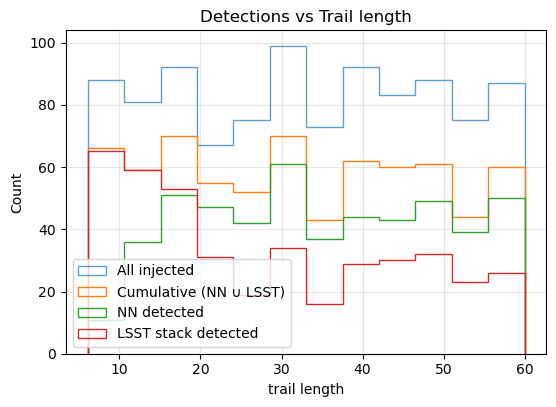

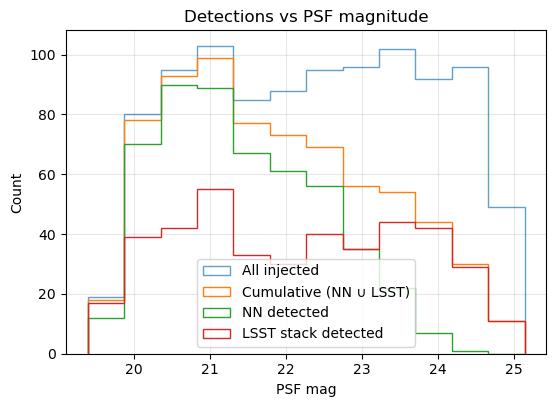

In [23]:
catalog_csv = "../DATA/test.csv"   # ← adjust if needed
cat = mark_nn_and_stack(catalog_csv, p_test, radius=3, thr=0.5)
# fields as in your CSV
plot_detect_hist(cat, "trail_length", bins=12, title="Detections vs Trail length")
plot_detect_hist(cat, "PSF_mag",      bins=12, title="Detections vs PSF magnitude")

In [24]:
tot = len(cat)
nn  = int(cat["nn_detected"].sum())
stk = int(cat["stack_detected"].sum())
cum = int((cat["nn_detected"] | cat["stack_detected"]).sum())
print(f"NN: {nn}/{tot} | LSST stack: {stk}/{tot} | Cumulative: {cum}/{tot}")

NN: 510/1000 | LSST stack: 417/1000 | Cumulative: 702/1000


In [26]:
import h5py, numpy as np
from scipy.ndimage import label as cc_label, find_objects

# Config
IOU_THR = 0.10        # component vs GT IoU threshold to call a TP; else FP
MIN_PIX = 5           # ignore tiny specks (<5 px) as noise
STRUCT = np.ones((3,3), dtype=np.uint8)  # 8-connected components

# Load GT masks from your HDF5 test set
test_h5 = "../DATA/test.h5"  # adjust if needed
with h5py.File(test_h5, "r") as f:
    gt_full = f["masks"][:].astype(np.uint8)  # shape (N,H,W), 0/1

# Ensure we have a binary NN mask (you likely already have bin_full)
thr = 0.5
if 'bin_full' not in globals():
    bin_full = (p_test >= thr).astype(np.uint8)  # p_test from earlier cells

N, H, W = bin_full.shape
assert gt_full.shape == (N, H, W), "GT and prediction shapes must match."

def iou(a, b):
    inter = (a & b).sum()
    union = (a | b).sum()
    return float(inter) / float(union) if union > 0 else 0.0

# Per-image stats and component tables
fp_rows = []
tp_rows = []
per_image_summary = []

for i in range(N):
    pred = bin_full[i]
    gt   = gt_full[i]

    # label components in prediction
    L, n = cc_label(pred, structure=STRUCT)
    slices = find_objects(L) if n > 0 else []

    fp_count = tp_count = 0
    fp_pix = tp_pix = 0

    for k, slc in enumerate(slices, start=1):
        comp_mask = (L[slc] == k)
        comp_size = int(comp_mask.sum())
        if comp_size < MIN_PIX:
            continue

        # compute IoU with GT (restrict to bbox for speed)
        gt_local = gt[slc].astype(bool)
        iou_k = iou(comp_mask, gt_local)

        # record TP / FP
        bbox = (slc[0].start, slc[0].stop, slc[1].start, slc[1].stop)  # (r0,r1,c0,c1)
        # centroid in image coords
        ys, xs = np.where(comp_mask)
        cy = int(ys.mean()) + bbox[0]
        cx = int(xs.mean()) + bbox[2]

        if iou_k >= IOU_THR:
            tp_count += 1
            tp_pix += comp_size
            tp_rows.append(dict(image_id=i, size=comp_size, iou=iou_k, cy=cy, cx=cx, bbox=bbox))
        else:
            fp_count += 1
            fp_pix += comp_size
            fp_rows.append(dict(image_id=i, size=comp_size, iou=iou_k, cy=cy, cx=cx, bbox=bbox))

    total_pred_pix = int(pred.sum())
    total_gt_pix   = int(gt.sum())
    per_image_summary.append(dict(
        image_id=i,
        n_components=int(n),
        tp_components=int(tp_count),
        fp_components=int(fp_count),
        tp_pixels=int(tp_pix),
        fp_pixels=int(fp_pix),
        pred_pixels=int(total_pred_pix),
        gt_pixels=int(total_gt_pix),
        fp_rate_pixels = (fp_pix / max(total_pred_pix, 1)),
    ))

import pandas as pd
df_fp = pd.DataFrame(fp_rows)
df_tp = pd.DataFrame(tp_rows)
df_sum = pd.DataFrame(per_image_summary)

print("FP components:", len(df_fp), "| TP components:", len(df_tp))
df_sum.describe()


FP components: 24082 | TP components: 763


,image_id,n_components,tp_components,fp_components,tp_pixels,fp_pixels,pred_pixels,gt_pixels,fp_rate_pixels
count,50.00000,50.00000,50.000000,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,24.50000,577.14000,15.260000,481.64000,30232.000000,148065.220000,178513.880000,55496.360000,0.815315
std,14.57738,238.35114,5.382549,203.35259,11307.830843,70055.135674,74052.305954,3246.464424,0.060800
min,0.00000,234.00000,4.000000,179.00000,7709.000000,30086.000000,42766.000000,49234.000000,0.613437
25%,12.25000,460.00000,10.250000,385.25000,22852.000000,105440.500000,136827.500000,53972.000000,0.791224
50%,24.50000,544.00000,15.500000,457.00000,31450.500000,140075.000000,174575.500000,56489.000000,0.816826
75%,36.75000,619.00000,19.000000,524.00000,37400.000000,185994.250000,224005.750000,57501.750000,0.850283
max,49.00000,1472.00000,30.000000,1235.00000,53012.000000,399211.000000,408205.000000,62916.000000,0.977967


In [27]:
TP = len(df_tp)
FP = len(df_fp)

# Optional: count GT "objects" as connected components on gt masks:
gt_comps = []
for i in range(N):
    Lg, ng = cc_label(gt_full[i], structure=STRUCT)
    gt_comps.append(ng)
FN = int(np.sum(gt_comps)) - TP

precision = TP / max(TP + FP, 1)
recall    = TP / max(TP + FN, 1)
f1        = 2 * precision * recall / max(precision + recall, 1e-8)

print(f"Object-level  P={precision:.3f}, R={recall:.3f}, F1={f1:.3f}  (thr={thr}, IoU_thr={IOU_THR})")


Object-level  P=0.031, R=0.765, F1=0.059  (thr=0.5, IoU_thr=0.1)


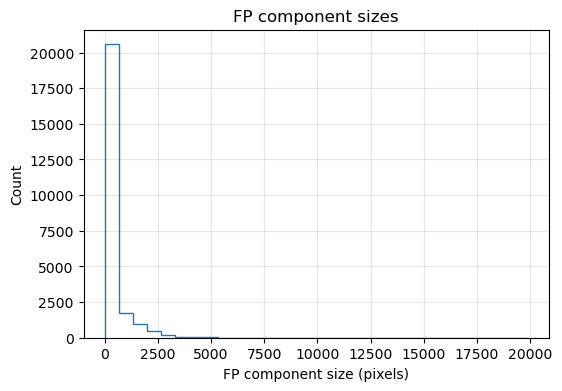

In [28]:
import matplotlib.pyplot as plt
if not df_fp.empty:
    plt.figure(figsize=(6,4))
    plt.hist(df_fp["size"], bins=30, histtype="step")
    plt.xlabel("FP component size (pixels)")
    plt.ylabel("Count"); plt.grid(True, alpha=0.3); plt.title("FP component sizes")
    plt.show()


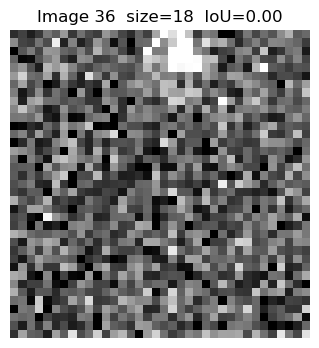

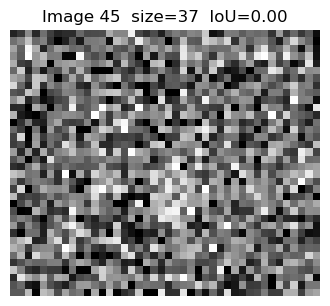

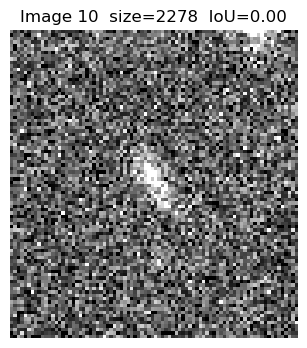

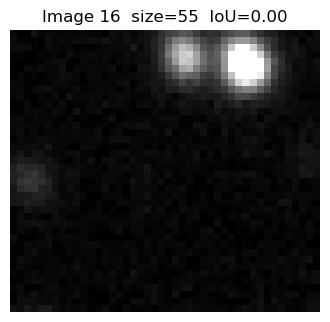

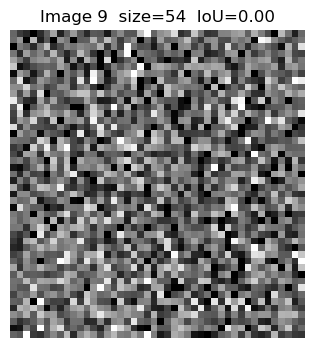

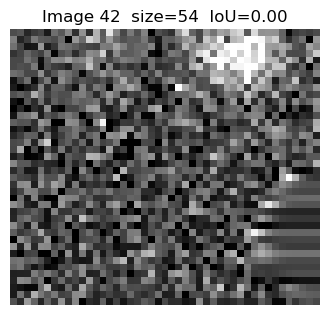

In [29]:
def show_fp_examples(h5_path, df_fp, k=6, pad=16):
    import random
    with h5py.File(h5_path, "r") as f:
        X = f["images"]
        for row in df_fp.sample(min(k, len(df_fp)), random_state=0).itertuples():
            i, (r0,r1,c0,c1) = row.image_id, row.bbox
            # add a little pad around bbox
            rr0 = max(0, r0 - pad); rr1 = min(X.shape[1], r1 + pad)
            cc0 = max(0, c0 - pad); cc1 = min(X.shape[2], c1 + pad)
            img = X[i, rr0:rr1, cc0:cc1]

            plt.figure(figsize=(4,4))
            plt.imshow(img, cmap="gray", vmin=np.percentile(img,5), vmax=np.percentile(img,99))
            plt.title(f"Image {i}  size={row.size}  IoU={row.iou:.2f}")
            plt.axis("off"); plt.show()

show_fp_examples(test_h5, df_fp, k=6)
